# Probabilistic machine learning and Bayesian neural networks

### 1. Bernoulli distribution example

First, lets have a look at the Bernoulli distribution with a simple example of the the weather as being either good or bad, i.e., 

$$ weather = \{Bad, Good\}, $$

using the shorthand encoded 

$$ w = \{0, 1\}, $$

with the probability density function

$p(w) = \theta^w (1 - \theta)^{(1 - w)}$

where $ \theta = $ probability of good weather and $ w \sim Bernoulli(\theta)$ are our observations. Lets assume we have good weather at a 80 % rate, so $ \theta = 0.8$. 


In [1]:
# importing some important libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# utils
from utils.plotting_utils import plot_bernoulli_data
from utils.plotting_utils import plot_fake_probabilistic_regression_model


Lets define the weather distribution

$p(w) = \theta^w (1 - \theta)^{(1 - w)}$

In [20]:
good_weather_truth = 0.8
weather = tfd.Bernoulli(probs=good_weather_truth, name="weather_probability")

Now lets produce our dataset, which will display something like $D = \{Good, Bad, Good, Good, Good, ...\} = \{1, 0, 1, 1, 1, ...\}  $ 

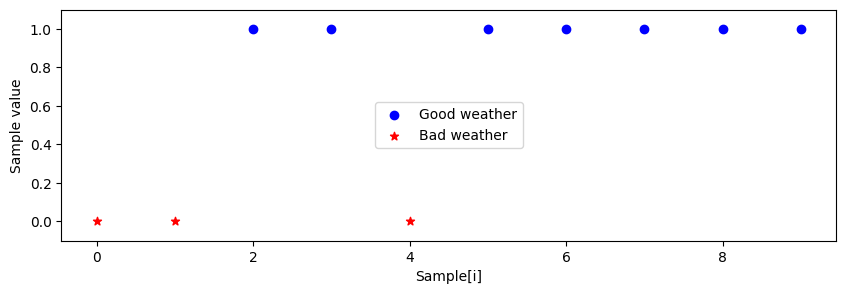

In [21]:
number_of_samples = 10
weather_dataset = weather.sample(number_of_samples)
plot_bernoulli_data(dataset=weather_dataset, p="Good weather", q="Bad weather")

Lets have a look at the data

and lets look at the likelihood of the dataset, defined as

$$ p(D) = \prod_{i=0} ^ {N - 1} p(W = w^{[i]}) = \prod_{i=0} ^ {N - 1} \theta^{w^{[i]}} (1 - \theta)^{(1 - w^{[i]})}  $$

i.e., its just a series of products of the observations $w^{[i]}$, $ i=0, 1, ...$ 

In [18]:
weather_probs = weather.prob(dataset)
likelihood = tf.reduce_prod(weather_probs)
print("The probabilities: ", weather_probs.numpy())
print("", likelihood.numpy())

[0.19999999 0.19999999 0.19999999 0.19999999 0.79999995 0.79999995
 0.79999995 0.79999995 0.79999995 0.19999999]
0.000104857536


Lets assume we do not know the true parameter $\theta$, but instead have to estimated it from the data. For this we can use the Maximum Likelihood Estimation (MLE) technique, where we try to maximize the likelihood given the data, or minimize the negative log-likelihood, i.e.,

$$ \ell (D; \theta) = \log \prod_{i=0} ^ {N - 1} p(W = w^{[i]}) =  \sum_{i=0} ^ {N - 1} \log p(W = w^{[i]}) =  \sum_{i=0} ^ {N - 1} w^{[i]}\log (\theta) + (1 - w^{[i]})\log(1 - w^{[i]})  $$

our estimator is the parameter that maximizes the log-likelihood, i.e.,

$$ \theta^{*} = \argmax_{\theta \in [0, 1]} \sum_{i=0} ^ {N - 1} w^{[i]}\log (\theta) + (1 - w^{[i]})\log(1 - w^{[i]}). $$

This can be colapsed into a the simple solution of being the mean of the dataset

$$ \theta^{*} = \frac{1}{N} \sum_{i=0}^{N-1} w^{[i]} $$


In [6]:
number_of_samples = 10
dataset_new = weather.sample(number_of_samples)
estimate = tf.reduce_mean(tf.cast(dataset_new, float)).numpy()
print("The estimate of the probability for weather being good: ", estimate)

The estimate of the probability for weather being good:  0.8


Lets try a different approach, using automatic differentation, i.e., gradient-based optimization. In this case we want to, instead of maximizing, but minimizing the negative log-likelihood, i.e.,

$$ \theta^{*} = \argmin_{\theta \in [0, 1]}  - \sum_{i=0} ^ {N - 1} \ell (D; \theta). $$

First, lets model parameter we want to optimize for

In [7]:
initial_guess = 0.5
weather_theta =  tfp.util.TransformedVariable(initial_value=initial_guess, bijector=tfp.bijectors.SoftClip(low=0.0, high=1.0), name="weather_estimate")
weather_theta

<TransformedVariable: name=weather_estimate, dtype=float32, shape=[], fn="soft_clip", numpy=0.5>

and the distribution

In [8]:
weather_fit = tfd.Bernoulli(probs=weather_theta, name="weather_fit")

and then the negative log-likelihood, which is the loss function

$$Loss = - \sum_{i=0} ^ {N - 1} \ell (D; \theta) = - \sum_{i=0} ^ {N - 1} w^{[i]}\log (\theta) + (1 - w^{[i]})\log(1 - w^{[i]}),$$

which is just the negative sum over all log-probabilities

In [9]:
neg_log_likelihood = lambda : - tf.reduce_sum(weather_fit.log_prob(dataset_new))
print("Initial value of the loss: ", neg_log_likelihood().numpy())

Initial value of the loss:  6.931472


This can be minimized easily by using tensorflow probability math.minimize and choosing a proper gradient-based optimizer

In [10]:
tfp.math.minimize(loss_fn=neg_log_likelihood, optimizer=tf.optimizers.Adam(learning_rate=0.1), num_steps=100)

2023-02-24 16:33:16.304160: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-24 16:33:16.304311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([6.931472 , 6.6534395, 6.3993626, 6.1693735, 5.963376 , 5.7810144,
       5.621676 , 5.4844894, 5.3683395, 5.271882 , 5.1935835, 5.1317506,
       5.0845833, 5.0502195, 5.026786 , 5.0124464, 5.0054474, 5.0041504,
       5.0070662, 5.0128717, 5.020425 , 5.028763 , 5.037108 , 5.044852 ,
       5.051547 , 5.05689  , 5.0607047, 5.0629234, 5.0635715, 5.0627456,
       5.0606   , 5.057332 , 5.0531626, 5.048329 , 5.043069 , 5.037611 ,
       5.0321693, 5.0269322, 5.0220594, 5.0176754, 5.0138717, 5.010701 ,
       5.0081863, 5.0063133, 5.005041 , 5.0043077, 5.004032 , 5.0041237,
       5.004485 , 5.0050225, 5.005647 , 5.006282 , 5.0068617, 5.0073385,
       5.0076814, 5.007872 , 5.0079107, 5.0078044, 5.0075746, 5.007247 ,
       5.0068507, 5.0064163, 5.0059714, 5.005542 , 5.005149 , 5.004807 ,
       5.004527 , 5.004311 , 5.00416  , 5.004068 , 5.004028 , 5.0040293,
       5.0040617, 5.004114 , 5.004175 , 5.0042386, 5.0042944, 5.0043387,
  

In [22]:
print("The estimate for good weather: ", weather_theta.numpy())

The estimate of the probability for weather being good:  0.79999995


### 2. Normal distribution and probabilistic regression

Ok, now lets look into regression from a probabilistic perspective. 

<img src="imgs/ProbabilisticRegression.png" width="800" height="400">



In [ ]:
plot_fake_probabilistic_regression_model(number_of_models=10)